<a href="https://colab.research.google.com/github/pnewmatt/github.io/blob/master/Uncovering_Politics_in_Urban_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab Notebook Assignment: Uncovering Politics in Urban Data with Analysis & Machine Learning


1. Introduction
Welcome! This assignment builds upon the lecture's core idea: technological artifacts and systems, even seemingly neutral ones, embody political power and reflect societal choices. We will explore this by analyzing NYC 311 service request data. You will run pre-written code for data analysis and a simple machine learning task, and your main role will be to critically interpret the findings through the lens of the lecture.

The Big Questions (from the lecture):

Is any part of the technological process (including data analysis and ML) neutral?
How is a societal worldview embedded in systems and the data they generate?
What are the first- and second-order effects of these systems?
2. Learning Objectives
By completing this assignment, you will:

Observe how data analysis can reveal patterns related to urban infrastructure and services.
Understand how machine learning can be applied to civic data to uncover potential disparities.
Critically interpret data visualizations and ML model results in the context of social and political implications.
Connect empirical findings from data to theoretical concepts about the politics of artifacts and systems.
Reflect on the ethical responsibilities and potential impacts of using data science for social analysis.
3. The Dataset: NYC 311 Service Requests
We are using a sample of the NYC 311 Service Request dataset. Residents use 311 to report non-emergency issues. This data can reflect the state of urban infrastructure ("artifacts"), service delivery ("systems"), and potential disparities.

4. Setup: Importing Libraries
This cell imports all necessary Python libraries for data manipulation, visualization, and machine learning.

(Execute the code cell below)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

# Set some display options and styles
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100) # Show more text in columns
plt.style.use('ggplot')
sns.set_palette("pastel")
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore some common FutureWarnings from sklearn/pandas
warnings.filterwarnings('ignore', category=UserWarning) # Ignore some common UserWarnings

print("Libraries imported successfully!")


Libraries imported successfully!


5. Data Loading and Initial Preparation
We'll load a sample of records from the NYC 311 dataset and perform initial cleaning and feature engineering.

(Execute the code cell below)

In [ ]:
# URL for the NYC 311 Service Requests CSV data (limit to 75,000 records for a larger sample)
csv_url = "https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=75000" # Increased sample size
df_311 = None # Initialize to None

try:
    df_311 = pd.read_csv(csv_url)
    print(f"Successfully loaded {len(df_311)} records.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure you have an internet connection. If issues persist, the data source might be temporarily unavailable or the URL changed.")

if df_311 is not None:
    print("\nFirst 5 rows of the raw dataset:")
    print(df_311.head())

    print(f"\nInitial dataset shape: {df_311.shape}")

    # --- Data Cleaning and Feature Engineering ---
    print("\n--- Starting Data Cleaning and Feature Engineering ---")

    # Select relevant columns
    # We'll try to find a good set of columns, including those needed for calculating resolution time
    potential_cols = ['unique_key', 'created_date', 'closed_date', 'agency',
                      'complaint_type', 'descriptor', 'location_type',
                      'incident_zip', 'city', 'borough', 'latitude', 'longitude']
    relevant_cols = [col for col in potential_cols if col in df_311.columns]
    df = df_311[relevant_cols].copy()

    print(f"\nSelected {len(relevant_cols)} relevant columns. Shape: {df.shape}")

    # Convert date columns to datetime objects
    print("\nConverting date columns to datetime...")
    if 'created_date' in df.columns:
        df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
    if 'closed_date' in df.columns:
        df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

    # Calculate Resolution Time (only for rows where both dates are valid)
    if 'created_date' in df.columns and 'closed_date' in df.columns:
        df_resolvable = df.dropna(subset=['created_date', 'closed_date']).copy()
        df_resolvable['resolution_time_days'] = (df_resolvable['closed_date'] - df_resolvable['created_date']).dt.total_seconds() / (24 * 60 * 60)
        # Filter out negative resolution times (data errors) and very long ones (potential outliers for this exercise)
        df_resolvable = df_resolvable[(df_resolvable['resolution_time_days'] >= 0) & (df_resolvable['resolution_time_days'] < 365*2)] # e.g. less than 2 years
        print(f"\nCalculated resolution time for {len(df_resolvable)} records.")
        print("Basic stats for resolution_time_days:")
        print(df_resolvable['resolution_time_days'].describe())

        # Define a binary target for "Long Resolution"
        if not df_resolvable.empty:
            median_resolution_time = df_resolvable['resolution_time_days'].median()
            df_resolvable['is_long_resolution'] = (df_resolvable['resolution_time_days'] > median_resolution_time).astype(int)
            print(f"\nMedian resolution time: {median_resolution_time:.2f} days. Used as threshold for 'is_long_resolution'.")
            print("'is_long_resolution' value counts:")
            print(df_resolvable['is_long_resolution'].value_counts(normalize=True))
        else:
            print("Not enough data to calculate median resolution time or 'is_long_resolution'.")
            df_resolvable['is_long_resolution'] = pd.Series(dtype=int) # Empty series
    else:
        print("\n'created_date' or 'closed_date' not found, cannot calculate resolution time.")
        # Create an empty dataframe for df_resolvable to prevent errors later, or handle flow
        df_resolvable = pd.DataFrame(columns=df.columns.tolist() + ['resolution_time_days', 'is_long_resolution'])


    # For general EDA, use the dataframe 'df' which has more records (not filtered by closable date yet)
    # Handle common missing values for key categorical features used in EDA
    cols_to_fill_unknown = ['complaint_type', 'borough', 'agency', 'location_type']
    for col in cols_to_fill_unknown:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    print("\nCleaned dataset 'df' (for EDA) info:")
    df.info()
    print("\nDataset 'df_resolvable' (for ML) info:") # This one will have the resolution time and target variable
    df_resolvable.info()

    print("\n--- Data Cleaning and Feature Engineering Complete ---")

Successfully loaded 75000 records.

First 5 rows of the raw dataset:
   unique_key             created_date closed_date agency  \
0    64854851  2025-05-06T01:45:12.000         NaN   NYPD   
1    64856896  2025-05-06T01:45:03.000         NaN   NYPD   
2    64858142  2025-05-06T01:44:26.000         NaN   NYPD   
3    64855607  2025-05-06T01:44:01.000         NaN   NYPD   
4    64858109  2025-05-06T01:43:43.000         NaN   NYPD   

                       agency_name      complaint_type        descriptor  \
0  New York City Police Department    Blocked Driveway         No Access   
1  New York City Police Department     Illegal Parking   Blocked Hydrant   
2  New York City Police Department  Noise - Commercial  Loud Music/Party   
3  New York City Police Department     Noise - Vehicle     Engine Idling   
4  New York City Police Department  Noise - Commercial  Loud Music/Party   

         location_type  incident_zip            incident_address  \
0      Street/Sidewalk       11207.0   

Interpretation Questions (after running the cell above):

How many records were initially loaded? After attempting to calculate resolution_time_days (in df_resolvable), how many records remained? What does this reduction tell you about the completeness of closed_date information in the original sample?
What is the median resolution time for complaints in df_resolvable? How was the is_long_resolution target variable created based on this?
Why is it important to handle missing data (like fillna('Unknown')) before analysis?

6. Exploratory Data Analysis (EDA) - Visualizing Patterns
Now, let's visualize some patterns in the data. All code is provided. Focus on interpreting the plots.

Part 6.1: What are People Complaining About?
(Execute the code cell below)

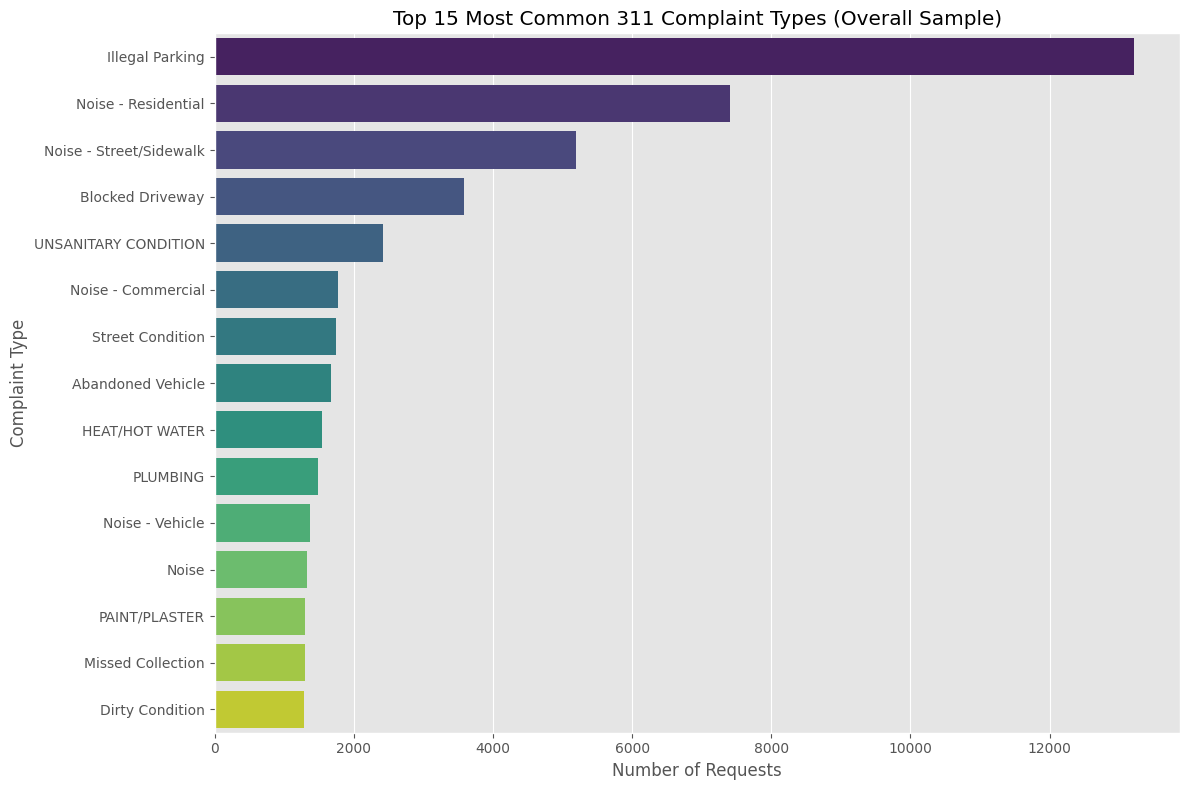

In [ ]:
if 'df' in locals() and 'complaint_type' in df.columns:
    plt.figure(figsize=(12, 8))
    # Use a larger number for top N to see more variety
    top_n = 15
    complaint_counts = df['complaint_type'].value_counts().nlargest(top_n)
    sns.barplot(y=complaint_counts.index, x=complaint_counts.values, palette="viridis")
    plt.title(f'Top {top_n} Most Common 311 Complaint Types (Overall Sample)')
    plt.xlabel('Number of Requests')
    plt.ylabel('Complaint Type')
    plt.tight_layout()
    plt.show()
else:
    print("Dataframe 'df' or 'complaint_type' column not available.")

nterpretation Questions (Part 6.1):

Looking at the bar chart, what are the 3-5 most frequent complaint types in this sample?
The lecture discussed how infrastructure (e.g., sidewalks, bridges) are "artifacts" with political dimensions. How do these common complaint types relate to the state or design of public/private infrastructure and essential services (e.g., housing, sanitation, utilities) in NYC?
Do any of these top complaints hint at systemic issues that might disproportionately affect vulnerable populations (e.g., issues related to housing quality, noise)? Explain your reasoning.

Part 6.2: Geographic Distribution - Complaints by Borough
(Execute the code cell below)

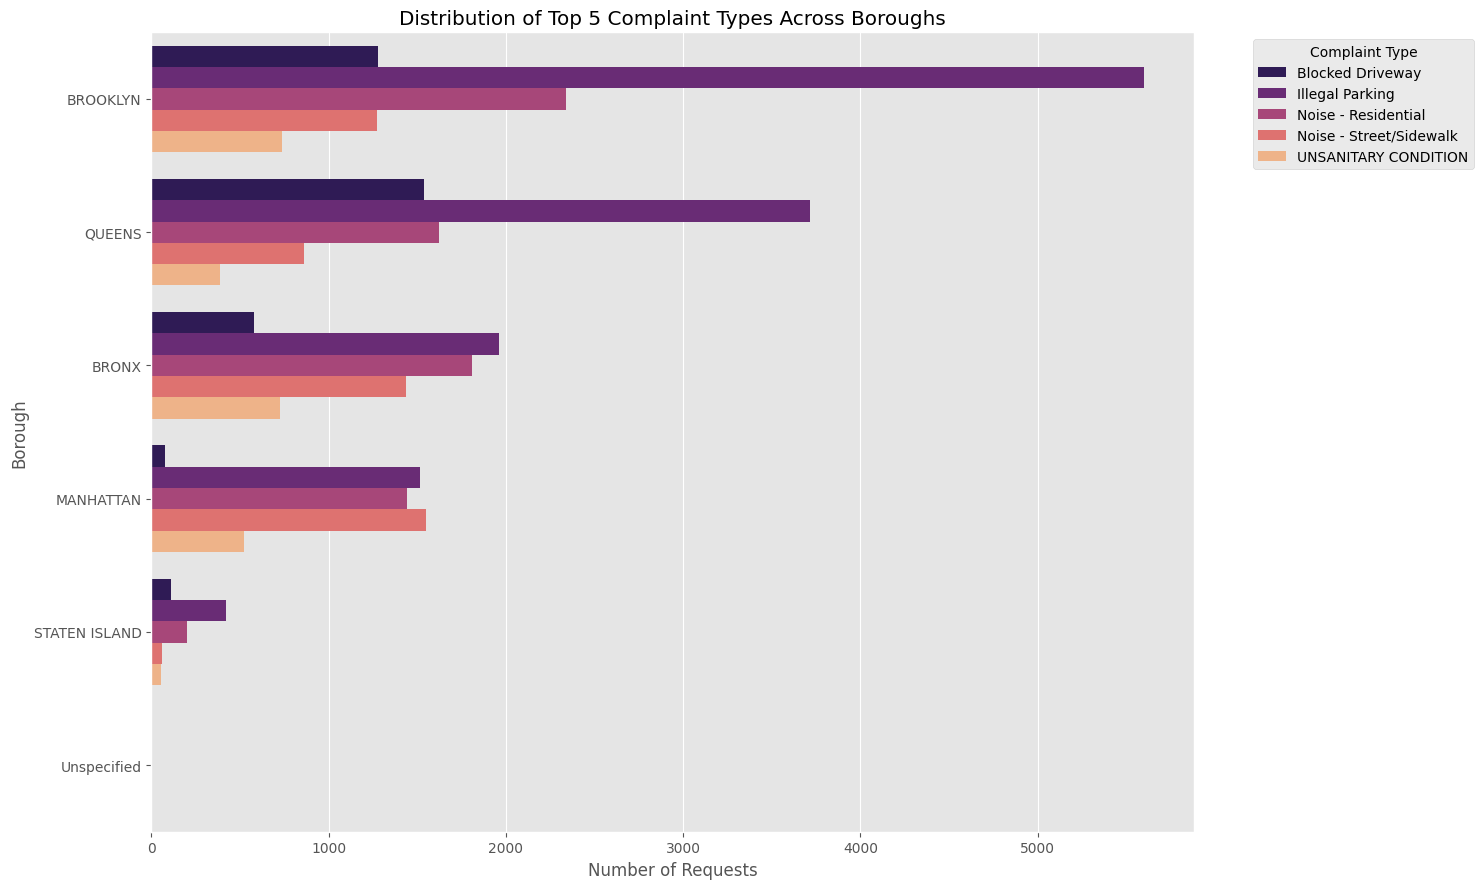

In [ ]:
if 'df' in locals() and 'borough' in df.columns and 'complaint_type' in df.columns:
    # Filter out 'Unknown' borough for cleaner visualization
    df_borough_eda = df[df['borough'] != 'Unknown']

    if not df_borough_eda.empty:
        # Let's look at the distribution of the overall top 5 complaint types across boroughs
        top_5_overall_complaints = df_borough_eda['complaint_type'].value_counts().nlargest(5).index.tolist()
        df_top_complaints_filtered = df_borough_eda[df_borough_eda['complaint_type'].isin(top_5_overall_complaints)]

        plt.figure(figsize=(15, 9))
        sns.countplot(data=df_top_complaints_filtered, y='borough', hue='complaint_type', order=df_top_complaints_filtered['borough'].value_counts().index, palette="magma")
        plt.title('Distribution of Top 5 Complaint Types Across Boroughs')
        plt.xlabel('Number of Requests')
        plt.ylabel('Borough')
        plt.legend(title='Complaint Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data with valid borough information for this plot.")
else:
    print("Dataframe 'df' or relevant columns not available for borough analysis.")

nterpretation Questions (Part 6.2):

Does the plot show noticeable differences in the types or volume of the top complaints across different boroughs? Describe one or two key observations.
The lecture used Robert Moses' bridges as an example of how infrastructure design can have political (and often discriminatory) consequences. If you see disparities here, how might they reflect historical or ongoing differences in investment, infrastructure quality, policy enforcement, or even demographic makeup influencing reporting behavior in different boroughs?
Who holds power regarding resource allocation and service standards across boroughs? How might such data be used by community groups or policymakers to argue for change?

Part 6.3: A Look at Resolution Times
Let's examine resolution times using df_resolvable (which contains complaints with valid start and end dates).

(Execute the code cell below)

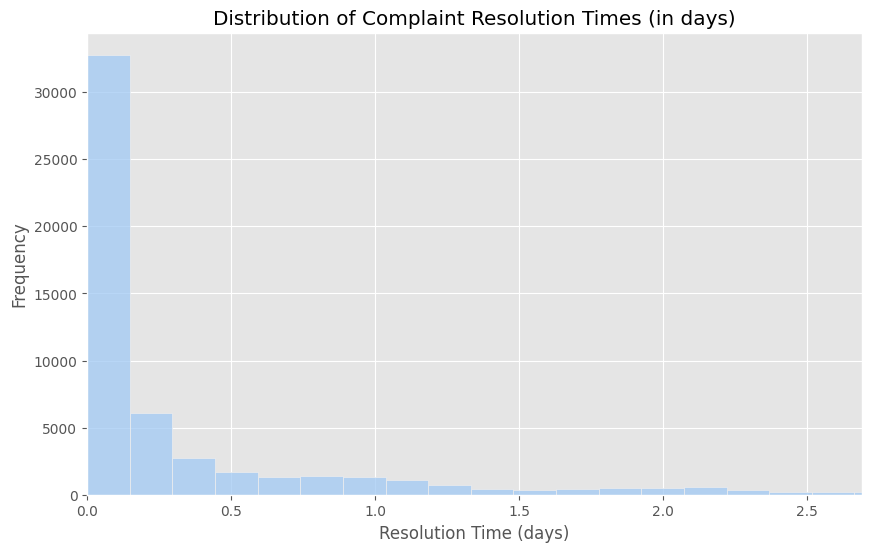

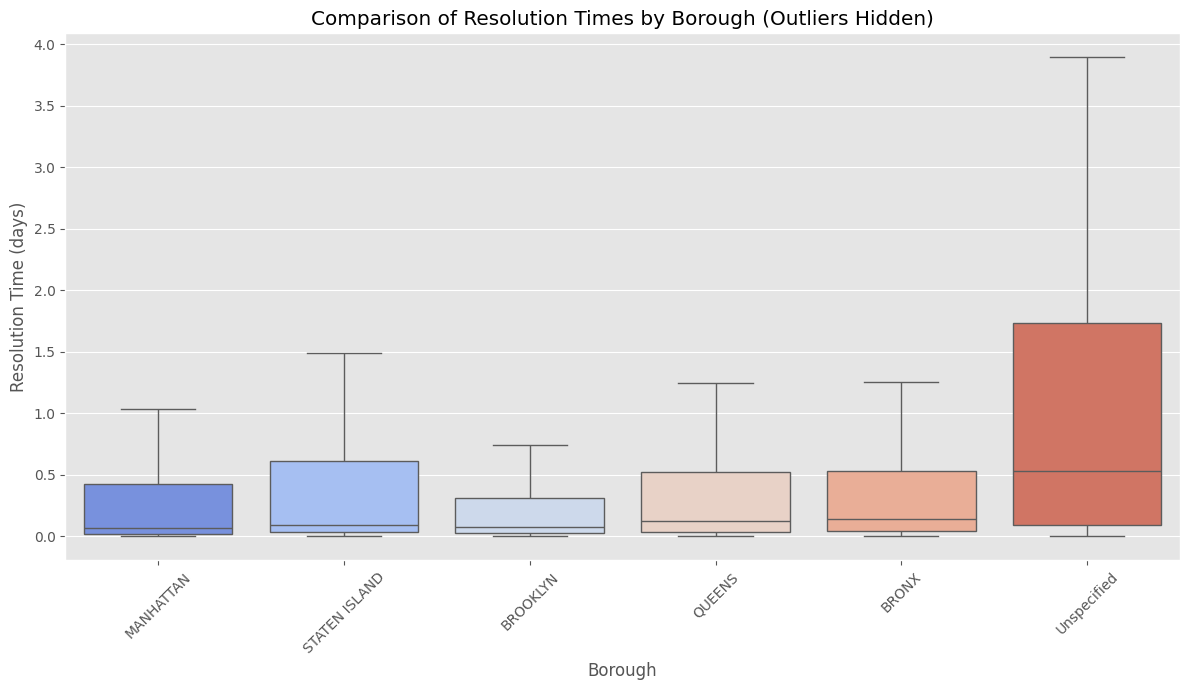

In [ ]:


if 'df_resolvable' in locals() and not df_resolvable.empty and 'resolution_time_days' in df_resolvable.columns and 'borough' in df_resolvable.columns:
    # Plot distribution of resolution times
    plt.figure(figsize=(10, 6))
    sns.histplot(df_resolvable['resolution_time_days'], bins=50, kde=False)
    plt.title('Distribution of Complaint Resolution Times (in days)')
    plt.xlabel('Resolution Time (days)')
    plt.ylabel('Frequency')
    plt.xlim(0, df_resolvable['resolution_time_days'].quantile(0.95)) # Show up to 95th percentile for better visibility
    plt.show()

    # Compare median resolution times by borough
    # Filter out 'Unknown' borough for cleaner visualization
    df_resolvable_borough = df_resolvable[df_resolvable['borough'] != 'Unknown']
    if not df_resolvable_borough.empty:
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_resolvable_borough, x='borough', y='resolution_time_days', palette="coolwarm", showfliers=False) # showfliers=False to hide outliers for clarity
        plt.title('Comparison of Resolution Times by Borough (Outliers Hidden)')
        plt.xlabel('Borough')
        plt.ylabel('Resolution Time (days)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data with valid borough information in df_resolvable for boxplot.")
else:
    print("Dataframe 'df_resolvable' or relevant columns not available for resolution time analysis.")


Interpretation Questions (Part 6.3):

Describe the general shape of the resolution time distribution from the histogram. Are most complaints resolved quickly, or do many take a long time?
Does the boxplot suggest any differences in complaint resolution times across boroughs? Which boroughs seem to have generally faster or slower median resolution times in this sample?
If disparities exist, how might these reflect the "political" nature of service delivery? Consider factors like resource allocation, bureaucratic efficiency, or the prioritization of issues in different areas. Who benefits from faster resolutions, and who is disadvantaged by delays?



7. Introduction to Machine Learning for Social Analysis
We've seen some patterns through EDA. Now, we'll use a simple machine learning model (a Decision Tree) to see if we can predict whether a complaint will have a "long resolution time" based on features like borough, complaint_type, and agency.

Why is this relevant to the "politics of artifacts"?
If our model can predict long resolution times, and if certain features (like the borough a complaint comes from) are strong predictors, it suggests that the system of complaint resolution (an "artifact" itself) might be operating in a way that produces systematically different outcomes. This can highlight embedded biases or inequities that are not immediately obvious.

8. Machine Learning: Predicting "Long Resolution Time"
All code for preprocessing, training, and evaluation is provided.

(Execute the code cell below. This cell might take a minute or two to run.)


--- Starting Machine Learning: Predicting Long Resolution Time ---
Using features for ML: ['borough', 'complaint_type', 'agency', 'location_type']

Training set size: 34762, Test set size: 14899

Training the Decision Tree model...
Model training complete.

Model Accuracy: 0.7189

Classification Report:
                     precision    recall  f1-score   support

Not Long Resolution       0.69      0.79      0.74      7492
    Long Resolution       0.76      0.64      0.69      7407

           accuracy                           0.72     14899
          macro avg       0.72      0.72      0.72     14899
       weighted avg       0.72      0.72      0.72     14899


Confusion Matrix:


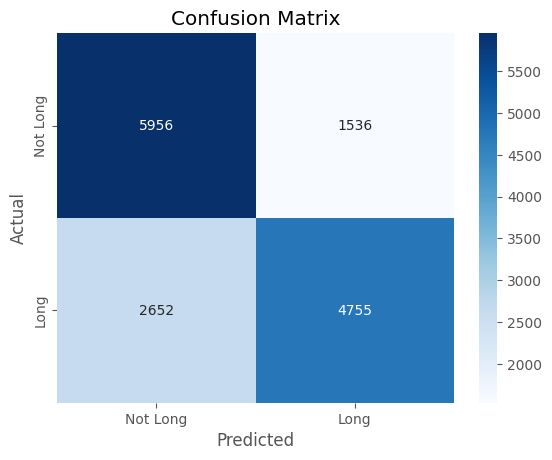


--- Feature Importance ---


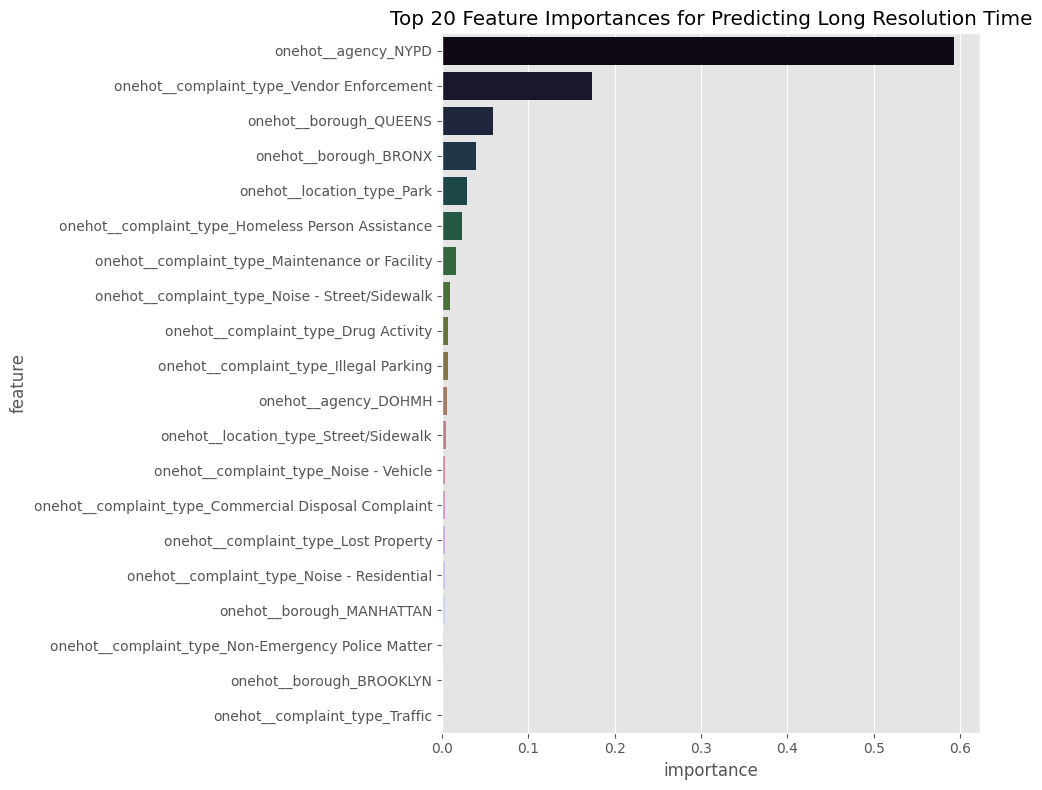


Top 10 most important features:
                                               feature  importance
115                                onehot__agency_NYPD    0.593237
102          onehot__complaint_type_Vendor Enforcement    0.174103
3                               onehot__borough_QUEENS    0.059231
0                                onehot__borough_BRONX    0.039559
151                         onehot__location_type_Park    0.028557
47   onehot__complaint_type_Homeless Person Assistance    0.022993
59      onehot__complaint_type_Maintenance or Facility    0.015636
69      onehot__complaint_type_Noise - Street/Sidewalk    0.008769
32                onehot__complaint_type_Drug Activity    0.007262
51              onehot__complaint_type_Illegal Parking    0.006765

--- Machine Learning Section Complete ---


In [ ]:
if 'df_resolvable' in locals() and not df_resolvable.empty and 'is_long_resolution' in df_resolvable.columns and df_resolvable['is_long_resolution'].notna().all():
    print("\n--- Starting Machine Learning: Predicting Long Resolution Time ---")

    # Define features (X) and target (y)
    # Using a subset of categorical features that are common and potentially influential
    # Ensure these columns exist and handle missing values if any survived previous cleaning
    features_for_ml = ['borough', 'complaint_type', 'agency', 'location_type']
    # Check if all selected features exist in df_resolvable
    existing_features_for_ml = [col for col in features_for_ml if col in df_resolvable.columns]

    if not existing_features_for_ml:
        print("Error: None of the selected features for ML exist in df_resolvable.")
    else:
        print(f"Using features for ML: {existing_features_for_ml}")
        # Drop rows where any of these key features or the target is missing
        df_ml = df_resolvable[existing_features_for_ml + ['is_long_resolution']].dropna().copy()

        if len(df_ml) < 100: # Check if enough data remains
             print(f"Warning: Very few records ({len(df_ml)}) remain after dropping NaNs from features/target. ML results may not be reliable.")

        if not df_ml.empty and 'is_long_resolution' in df_ml.columns and len(df_ml['is_long_resolution'].unique()) > 1:
            X = df_ml[existing_features_for_ml]
            y = df_ml['is_long_resolution']

            # Preprocessing: One-hot encode categorical features
            # Using ColumnTransformer to apply OneHotEncoder only to categorical features
            preprocessor = ColumnTransformer(
                transformers=[
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), existing_features_for_ml)
                ],
                remainder='passthrough' # In case we add numerical features later
            )

            # Create a pipeline with preprocessing and the classifier
            # Using a Decision Tree with max_depth to prevent overfitting and aid interpretation
            model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                             ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=20))])

            # Split data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
            print(f"\nTraining set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

            # Train the model
            print("\nTraining the Decision Tree model...")
            model_pipeline.fit(X_train, y_train)
            print("Model training complete.")

            # Make predictions
            y_pred = model_pipeline.predict(X_test)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            print(f"\nModel Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=['Not Long Resolution', 'Long Resolution']))
            print("\nConfusion Matrix:")
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Long', 'Long'], yticklabels=['Not Long', 'Long'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()


            # --- Feature Importance ---
            print("\n--- Feature Importance ---")
            try:
                # Get feature names after one-hot encoding
                feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
                importances = model_pipeline.named_steps['classifier'].feature_importances_
                feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
                feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

                plt.figure(figsize=(10, 8))
                # Plot top N feature importances
                top_n_features = 20
                sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n_features), palette="cubehelix")
                plt.title(f'Top {top_n_features} Feature Importances for Predicting Long Resolution Time')
                plt.tight_layout()
                plt.show()

                print("\nTop 10 most important features:")
                print(feature_importance_df.head(10))
            except Exception as e:
                print(f"Could not extract feature importances: {e}")
                print("This might happen if the preprocessor or classifier steps are named differently or if features are all dropped.")

            print("\n--- Machine Learning Section Complete ---")
        else:
            print("Not enough data or classes for ML after cleaning 'df_ml'. Skipping ML part.")
else:
    print("Dataframe 'df_resolvable' or target 'is_long_resolution' not available or suitable. Skipping ML part.")


9. Interpreting the Machine Learning Results
Now, carefully consider the output from the machine learning model.

Interpretation Questions (ML Results):

Model Performance:
What was the accuracy of the model on the test set?
Look at the Classification Report: How well did the model predict "Long Resolution" cases specifically (check precision and recall for the "Long Resolution" class)? Is the model better at predicting one class over the other?
Feature Importance:
Examine the "Feature Importances" plot and list. Which specific features (e.g., a particular borough, a specific complaint type) were among the most important for the model in predicting whether a complaint would have a long resolution time?
Connecting to "Politics of Artifacts":
If features like borough or specific complaint_type categories are highly important, what does this suggest about the 311 system and the city's response mechanisms (the "artifacts")? Does it imply that these systems might operate differently or produce different outcomes based on these factors?
How do these ML findings relate to the lecture's discussion of power, embedded bias, and who benefits or is disadvantaged by technological systems? For instance, if complaints from one borough are consistently predicted to have longer resolution times, who is being disadvantaged?
Potential Uses and Risks:
How could a model like this (even if imperfect) potentially be used for positive change (e.g., to identify areas needing more resources, or to proactively manage workload)?
What are some ethical risks or potential negative second-order effects of using such predictive models in city services? (Think about issues like self-fulfilling prophecies, misallocation of resources if the model is biased, or "gaming the system").


10. Broader Reflection
Reflect on the entire assignment – the EDA, the ML model, and the lecture's themes.

Neutrality of Technology & Data Science: The lecture asked, "Is there any part of the technological process that is neutral...?" After conducting this analysis (even by just running code and interpreting), do you think the data collection (311 calls), the data itself, the analytical methods (EDA, ML), or the interpretations can be truly neutral? Explain why or why not, using examples from this assignment.
Embedded Worldviews: How might societal worldviews or pre-existing biases be reflected in (a) the 311 complaint data itself (who complains, what they complain about) and (b) the way we might build an ML model to analyze it (e.g., choice of features, definition of "long resolution")?
First and Second-Order Effects: Consider the 311 system and the use of ML to analyze its data.
What is an intended (first-order) effect of analyzing 311 data with ML?
What is a potential unintended (second-order) negative effect that could arise from this type of analysis or its application by city officials?
What is a potential unintended (second-order) positive effect?

11. Limitations
Acknowledge the limitations of this specific analysis.

Data Sample: We used a limited sample of data.
Feature Engineering: Our definition of "long resolution" (median split) is one of many possibilities.
Model Simplicity: The Decision Tree is a relatively simple model.
Causation vs. Correlation: The model shows associations, not necessarily causation.
Bias in Reporting: The 311 data itself only reflects reported issues. What about unreported ones?


12. Conclusion
In one or two sentences, what is your main takeaway from exploring NYC 311 data through the lens of the lecture on the politics of artifacts, especially after seeing the machine learning component?
